In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import quickMTF.mtf as mtf
from quickMTF.mtf import SFR

%matplotlib inline

In [12]:
# algorithm parameters
supersampling = 4
show_plots = 5
mtf_index = 0.5
sequence=0
return_fig = False

diff_kernel = np.array([0.5, 0.0, -0.5])
diff_offset = 0.0
diff_ft = 2  # factor used in the correction of the numerical derivation

plot = True
verbose = False

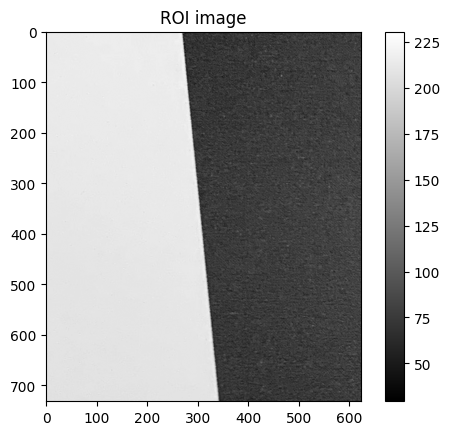

In [13]:
# load ROI image
image = np.load(r"..\quickMTF\sample_hori_edge.npy")
image = np.load(r"..\quickMTF\sample_vert_edge.npy")
# image = np.load(r"..\quickMTF\sample.npy")
# image = np.load(r"C:\Users\Lucas\Desktop\for\for Lucas\sample.npy")

sample = image

if plot:
    fig, ax = plt.subplots()
    im = ax.imshow(image, cmap='gray')
    fig.colorbar(im, ax=ax)
    plt.title("ROI image")
    plt.show()

(732,)


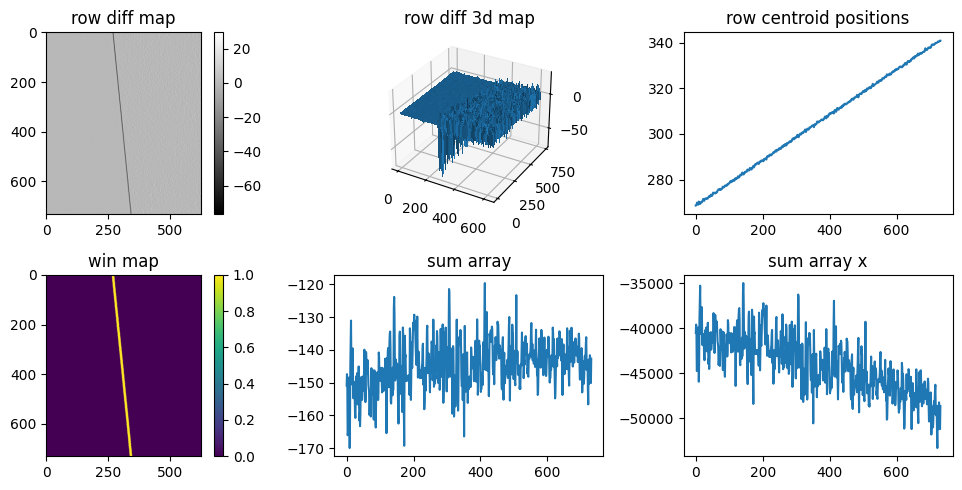

(623,)


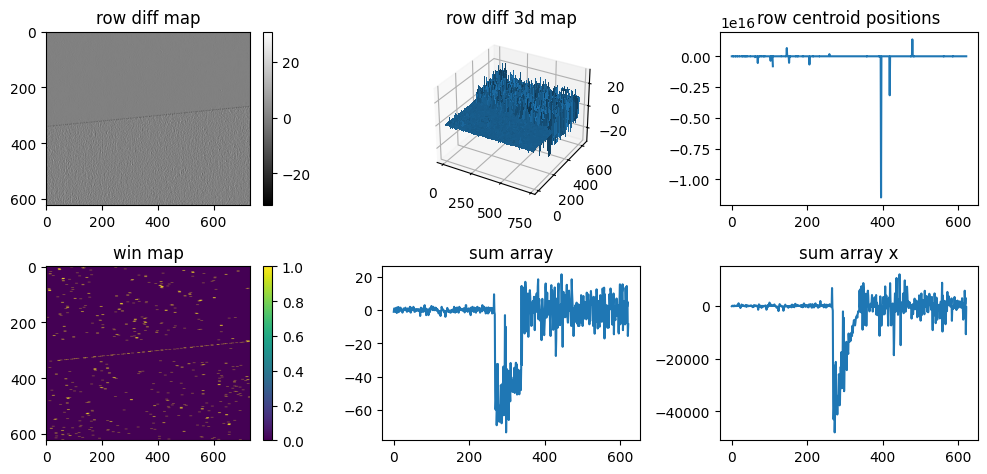

(732,)


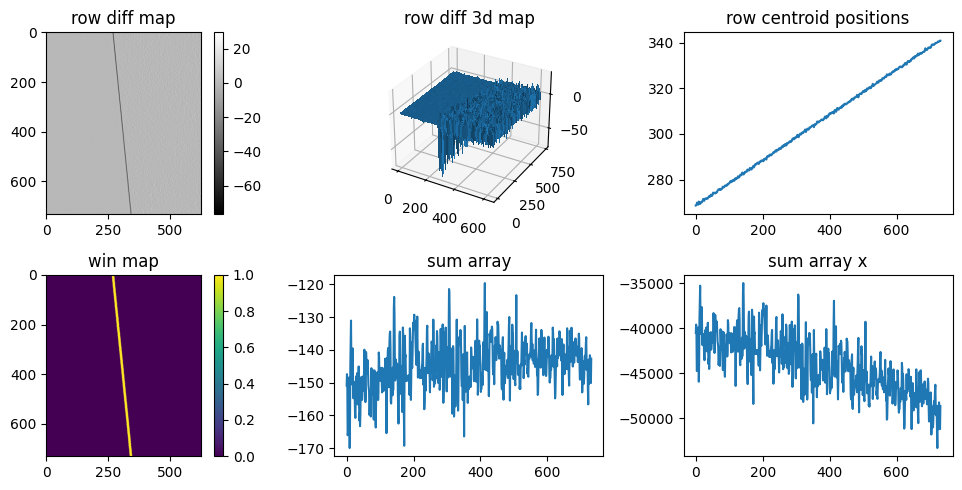

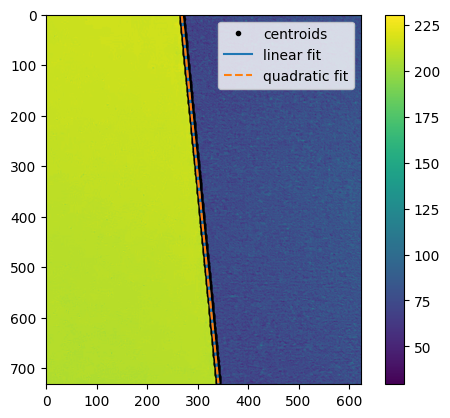

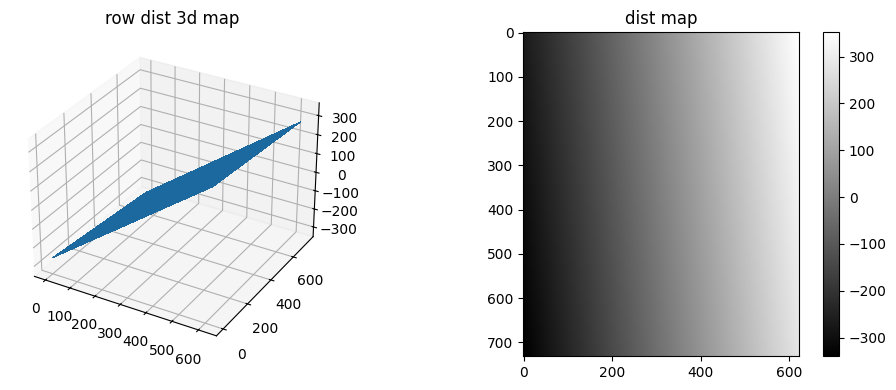

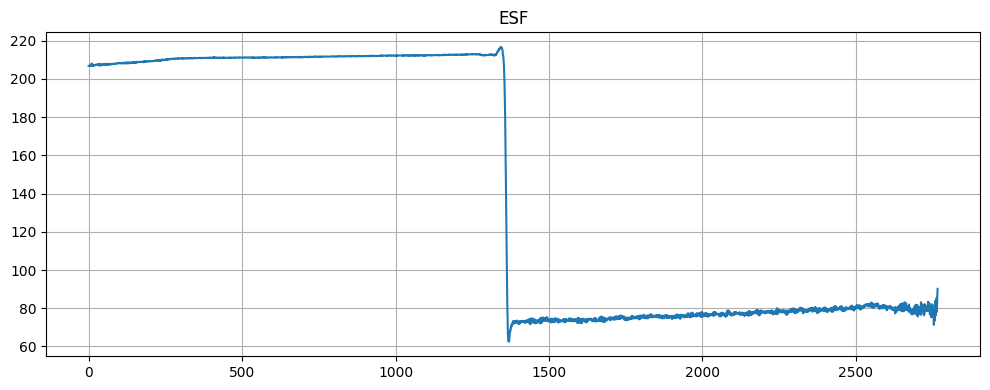

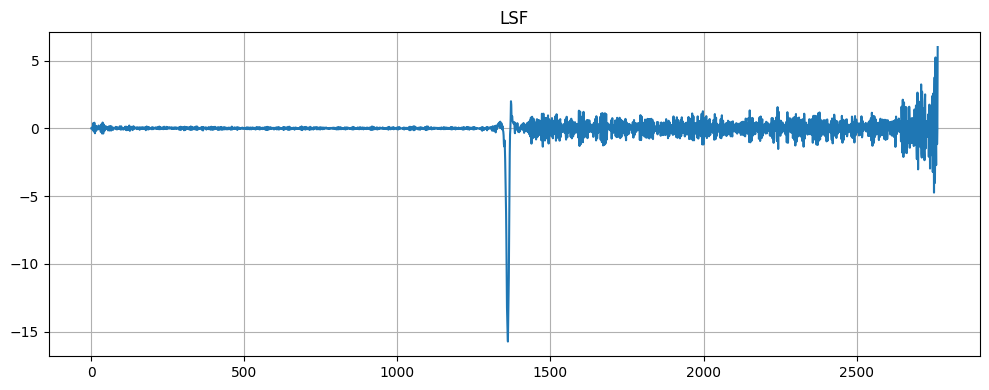

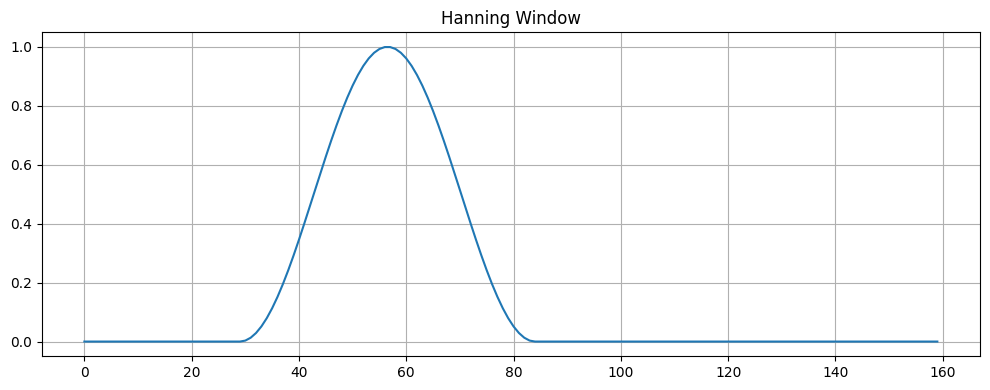

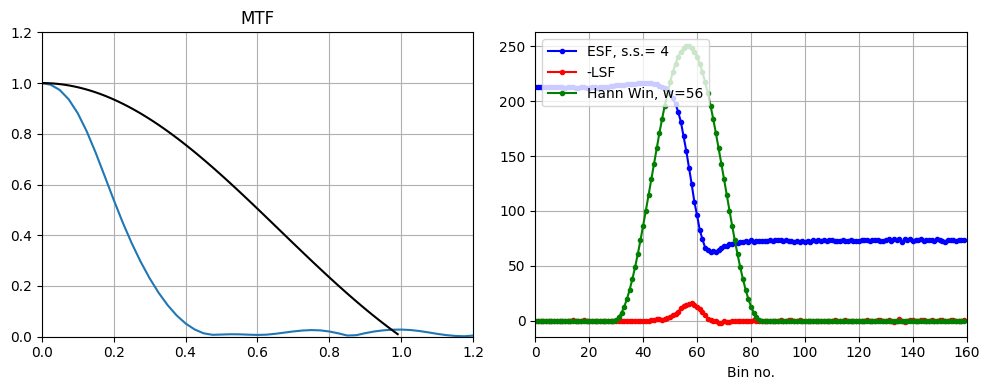

In [14]:
sfr = SFR(image)

original_roi_info, rotated_roi_info, centroid_info, edge_info, dist_info, esf_info, lsf_info, window_info, mtf_info, status_info = sfr.calculate_mtf()

sample_diff, sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x = original_roi_info
sample_diff_rot90, sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90 = rotated_roi_info
image_for_mtf, diff_for_mtf, centroid_for_mtf, win_for_mtf, sum_arr_for_mtf, sum_arr_x_for_mtf, rotated = centroid_info
if verbose:
    print(f"rotated: {rotated}")

if plot:
    mtf.plot_centroid_and_stats(sample_diff, sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x)

if plot:
    mtf.plot_centroid_and_stats(sample_diff_rot90, sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90)

if plot:
    mtf.plot_centroid_and_stats(diff_for_mtf, centroid_for_mtf, win_for_mtf, sum_arr_for_mtf, sum_arr_x_for_mtf)

pcoefs, slope, offset, angle, idx, patch_shape, centr = edge_info
if verbose:
    print(f"pcoefs: {pcoefs}")
    print(f"slope: {slope}")
    print(f"angle: {angle}")
    print(f"idx: {idx}")
    print(f"patch_shape: {patch_shape}")
    print(f"image_for_mtf.shape: {image_for_mtf.shape}")

if plot:
    mtf.plot_edge_and_stats(image_for_mtf, pcoefs, slope, offset, angle, idx, patch_shape, centr, rotated)

# Calculate distance (with sign) from each point (x, y) in the
# image patch "data" to the slanted edge
quadratic_fit = False
dist = dist_info
if verbose:
    print(f"dist.shape: {dist.shape}")

if plot:
    mtf.plot_dist_and_stats(dist)

# ESF
esf = esf_info  # edge spread function
if verbose:
    print(f"esf.shape: {esf.shape}")
    
if esf is False:
    print("esf is invalid")

if plot:
    mtf.plot_esf_and_stats(esf)

## LSF
lsf = lsf_info  # line spread function

if plot:
    mtf.plot_lsf_and_stats(lsf[0:-1])

## Hann window
hann_win, hann_width, idx2 = window_info  # define window to be applied on LSF
if hann_width >350:  # sorting out no slant edge
    print("wrong!")

if verbose:
    print(f"hann_width: {hann_width}")
    print(f"idx: {idx}")

if plot:
    mtf.plot_filter_window_and_stats(hann_win)

## MTF
mtf_result, cp_filter, angle, mtf_nyquist = mtf_info

## status
rotated, angle_cw, offset = status_info

mtf.plot_mtf_and_stats(mtf_result, esf, hann_win, hann_width, lsf, idx2, supersampling)